### Title: A Machine Learning Approach to Email Spam Detection

In this project, we aim to develop a machine learning algorithm to accurately classify emails as either spam or legitimate (ham). The increase in email usage has led to a surge in spam emails, which can be both annoying and harmful. We aim to create a robust spam detection system that helps users filter out unwanted messages and maintain a clean inbox. We are using a [Spam email classification Dataset from kaggle.com](https://www.kaggle.com/datasets/ashfakyeafi/spam-email-classification) with a total of 5,574 unique and legitimate email messages downloaded from the Kaggle website.

**Objectives:**

0.	Data Collection: Gather a comprehensive dataset of emails, including both spam and ham, from reliable sources such as the Enron Email Dataset or the SpamAssassin Public Corpus, or kaggle.
1.	Data Preprocessing: Clean and preprocess email data by removing irrelevant information, normalizing text, and handling missing values.
2.	Feature Extraction: Extract relevant features from the email text, such as word frequency, n-grams, and other textual attributes that can help distinguish between spam and ham.
3.	Model Development: Train various machine learning models (e.g., Naive Bayes, Support Vector Machines, and Neural Networks) on the preprocessed dataset to classify emails.
4.	Model Evaluation: Evaluate the model’s performance using metrics like accuracy, precision, recall, and F1-score. Select the best-performing model for deployment.
5.	Implementation: Develop a user-friendly interface where users can input new emails and receive instant classification results.
6.	Deployment: Deploy the model as a web service or integrate it into existing email systems to provide real-time spam detection.

**Expected Outcomes:**
* A high-accuracy email spam classification model.
* An efficient preprocessing and feature extraction pipeline.
* A user-friendly interface for real-time spam detection.
* Improved email management and reduced risk from spam emails for users.

By the end of this project, we aim to provide a reliable and efficient solution to the email spam problem, enhancing the user experience and security of email communication.


In [7]:
# Importing the libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [8]:
# Importing the dataset
df = pd.read_csv('email.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


#### 1. Data Preprocessing

In [10]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# Count of duplicated rows
df.duplicated().sum()

415

> There are 415 duplicated rows to drop.

In [12]:
#removing duplicates
df = df.drop_duplicates()
df.shape

(5158, 2)

> At this point I would like to understand better the features and the dataset in overall by plotting a few Graphs.
I would like to start by checking whether the dataset is balanced or not in terms of the outcome variable `spam`.

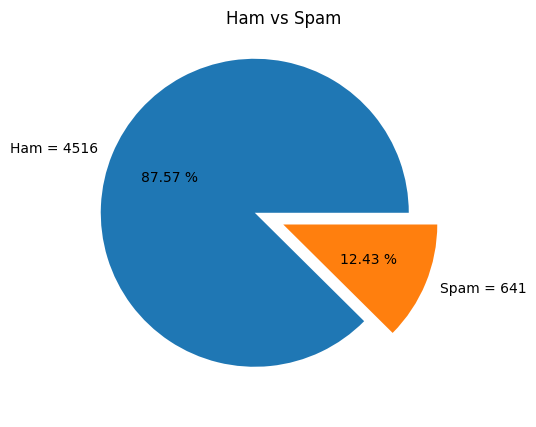

In [13]:
# Creating a Pie chart for spam and ham

number_of_spam = df[df['Category'] == 'spam'].shape[0]
number_of_ham = df[df['Category'] == 'ham'].shape[0]

plt.figure(figsize=(6,5))

mail_categories = [number_of_ham, number_of_spam]
labels = [f"Ham = {number_of_ham}", f"Spam = {number_of_spam}"]
explode = [.2, 0]

plt.pie(mail_categories, labels=labels, explode=explode, autopct="%.2f %%")
plt.title("Ham vs Spam")

plt.show()

> The previous pie chart shows that the majority class (Ham) has over 8 times more samples than the minority class (Spam). This imbalance can be problematic for some machine learning models, as they might prioritize learning patterns from the majority class and overlook the minority class. To address this problem we are using **undersampling** reducing the number of examples from the majority class (Ham) to match the size of the minority class.

In [15]:
# Undersampling the ham data
spam = df[df['Category'] == 'spam']
ham = df[df['Category'] == 'ham']

ham_under = ham.sample(spam.shape[0])
df_under = pd.concat([ham_under, spam], axis=0)

df = df_under

df['Category'].value_counts()

Category
ham     641
spam    641
Name: count, dtype: int64

> Now, nest step is to remove punctuation. Text data can vary widely in terms of punctuation usage. Removing punctuation can help standardize the text, making it easier to process and analyze. For instance, "Hello!" and "Hello" would be treated as the same after removing punctuation. Punctuation marks often do not carry semantic meaning and can introduce noise into text data. By removing them, you focus on the actual words, which are typically more important for tasks like sentiment analysis, text classification, or keyword extraction.

In [16]:
# Removing punctuation
import string
string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df['Message'] = df['Message'].apply(remove_punctuation)
df.head()

,Category,Message
3951,ham,I got to video tape pple type in message lor U...
4138,ham,Just got to ltgt
4710,ham,Haha awesome I might need to take you up on th...
749,ham,Is there a reason weve not spoken this year An...
3687,ham,I get out of class in bsn in like ltgt minut...


#### 2. Feature Engineering

> Following data cleaning, we proceed to feature engineering. The initial step entails encoding the 'spam' feature using scikit-learn's LabelEncoder class.

In [17]:
# Using sci-kit learn to label encode the spam column

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])
df.tail()

,Category,Message
3951,0,I got to video tape pple type in message lor U...
4138,0,Just got to ltgt
4710,0,Haha awesome I might need to take you up on th...
749,0,Is there a reason weve not spoken this year An...
3687,0,I get out of class in bsn in like ltgt minut...


> To enrich the model's feature set, we can introduce two additional numerical features: word count and message length. 

* `Lenght:` This feature represents the number of characters in the message.
* `Words:` This feature represents the number of words in the message.

In [19]:
# Column to represent the length of the text

df['length'] = df['Message'].apply(len)
df.head()

,Category,Message,length
3951,0,I got to video tape pple type in message lor U...,146
4138,0,Just got to ltgt,17
4710,0,Haha awesome I might need to take you up on th...,70
749,0,Is there a reason weve not spoken this year An...,99
3687,0,I get out of class in bsn in like ltgt minut...,75


In [20]:
# Column with the number of words

def count_words(text):
    return len(text.split())

df['words'] = df['Message'].apply(count_words)
df.head()

,Category,Message,length,words
3951,0,I got to video tape pple type in message lor U...,146,34
4138,0,Just got to ltgt,17,4
4710,0,Haha awesome I might need to take you up on th...,70,15
749,0,Is there a reason weve not spoken this year An...,99,21
3687,0,I get out of class in bsn in like ltgt minut...,75,16


**Word tokenization:**

> Word tokenization, in the context of Natural Language Processing (NLP), is the process of splitting a piece of text into smaller units called tokens. The tokenizer splits the text based on predefined rules or delimiters. The most common delimiter is a whitespace character (space, tab, newline, etc.), resulting in individual words as tokens.

In [21]:
import nltk
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources (do this only once)
nltk.download('punkt')

def tokenize_text_nltk(text):
  # Lowercase the text
  text = text.lower()
  # Tokenize using NLTK word_tokenize
  tokens = word_tokenize(text)
  return tokens

df['tokens_nltk'] = df['Message'].apply(tokenize_text_nltk)

df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Category,Message,length,words,tokens_nltk
3951,0,I got to video tape pple type in message lor U...,146,34,"[i, got, to, video, tape, pple, type, in, mess..."
4138,0,Just got to ltgt,17,4,"[just, got, to, ltgt]"
4710,0,Haha awesome I might need to take you up on th...,70,15,"[haha, awesome, i, might, need, to, take, you,..."
749,0,Is there a reason weve not spoken this year An...,99,21,"[is, there, a, reason, weve, not, spoken, this..."
3687,0,I get out of class in bsn in like ltgt minut...,75,16,"[i, get, out, of, class, in, bsn, in, like, lt..."


**Removing Stop Words:**

> In Natural Language Processing (NLP), removing stop words is a technique where you eliminate frequently occurring, generic words from your text data. These stop words typically don't contribute much to the core meaning of a sentence and can even add noise to your analysis.

In [22]:
# removing stopwords

from nltk.corpus import stopwords

# Download necessary NLTK resources
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [t for t in tokens if t not in stop_words]

df['tokens_nltk'] = df['tokens_nltk'].apply(remove_stopwords)

df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Category,Message,length,words,tokens_nltk
3951,0,I got to video tape pple type in message lor U...,146,34,"[got, video, tape, pple, type, message, lor, u..."
4138,0,Just got to ltgt,17,4,"[got, ltgt]"
4710,0,Haha awesome I might need to take you up on th...,70,15,"[haha, awesome, might, need, take, doin, tonight]"
749,0,Is there a reason weve not spoken this year An...,99,21,"[reason, weve, spoken, year, anyways, great, w..."
3687,0,I get out of class in bsn in like ltgt minut...,75,16,"[get, class, bsn, like, ltgt, minutes, know, a..."


> Now let's add a new column to count the number of words after having removed the stop words.

In [23]:
# Column with the number of words for nltk tokens

def count_words_nltk(tokens):
    return len(tokens)

df['words_nltk'] = df['tokens_nltk'].apply(count_words_nltk)
df.head()

,Category,Message,length,words,tokens_nltk,words_nltk
3951,0,I got to video tape pple type in message lor U...,146,34,"[got, video, tape, pple, type, message, lor, u...",27
4138,0,Just got to ltgt,17,4,"[got, ltgt]",2
4710,0,Haha awesome I might need to take you up on th...,70,15,"[haha, awesome, might, need, take, doin, tonight]",7
749,0,Is there a reason weve not spoken this year An...,99,21,"[reason, weve, spoken, year, anyways, great, w...",9
3687,0,I get out of class in bsn in like ltgt minut...,75,16,"[get, class, bsn, like, ltgt, minutes, know, a...",8


> Note that the number of words decreased so we now have a cleaner text message.

Now, another thechnique we can use is Stemming or Lemmatization.

**Stemming/Lemmatization:** 
> While Stemming reduces words to their base form (e.g., "running" becomes "run"), Lemmatization uses a dictionary and morphological analysis to map a word to its base form, called a lemma. It considers the part of speech of the word and aims to identify the canonical form used in the dictionary. Lemmatization goes a step further, considering the part of speech (e.g., "better" becomes "good").  
In this step, we will use `Lemmatization`.

In [24]:
# Stemming/Lemmatization: using NLTK
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources 
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer() 

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]

df['lemmatized'] = df['tokens_nltk'].apply(lemmatize_text)

df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Category,Message,length,words,tokens_nltk,words_nltk,lemmatized
3951,0,I got to video tape pple type in message lor U...,146,34,"[got, video, tape, pple, type, message, lor, u...",27,"[got, video, tape, pple, type, message, lor, u..."
4138,0,Just got to ltgt,17,4,"[got, ltgt]",2,"[got, ltgt]"
4710,0,Haha awesome I might need to take you up on th...,70,15,"[haha, awesome, might, need, take, doin, tonight]",7,"[haha, awesome, might, need, take, doin, tonight]"
749,0,Is there a reason weve not spoken this year An...,99,21,"[reason, weve, spoken, year, anyways, great, w...",9,"[reason, weve, spoken, year, anyways, great, w..."
3687,0,I get out of class in bsn in like ltgt minut...,75,16,"[get, class, bsn, like, ltgt, minutes, know, a...",8,"[get, class, bsn, like, ltgt, minute, know, ad..."


#### 3. Data vizualization

In [25]:
# Convert lemmatized tokens back to text before plotting word cloud
def tokens_to_text(tokens):
    return ' '.join(tokens)
df['lemmatized_text'] = df['lemmatized'].apply(tokens_to_text)
df.head()

,Category,Message,length,words,tokens_nltk,words_nltk,lemmatized,lemmatized_text
3951,0,I got to video tape pple type in message lor U...,146,34,"[got, video, tape, pple, type, message, lor, u...",27,"[got, video, tape, pple, type, message, lor, u...",got video tape pple type message lor u free wa...
4138,0,Just got to ltgt,17,4,"[got, ltgt]",2,"[got, ltgt]",got ltgt
4710,0,Haha awesome I might need to take you up on th...,70,15,"[haha, awesome, might, need, take, doin, tonight]",7,"[haha, awesome, might, need, take, doin, tonight]",haha awesome might need take doin tonight
749,0,Is there a reason weve not spoken this year An...,99,21,"[reason, weve, spoken, year, anyways, great, w...",9,"[reason, weve, spoken, year, anyways, great, w...",reason weve spoken year anyways great week bes...
3687,0,I get out of class in bsn in like ltgt minut...,75,16,"[get, class, bsn, like, ltgt, minutes, know, a...",8,"[get, class, bsn, like, ltgt, minute, know, ad...",get class bsn like ltgt minute know advising


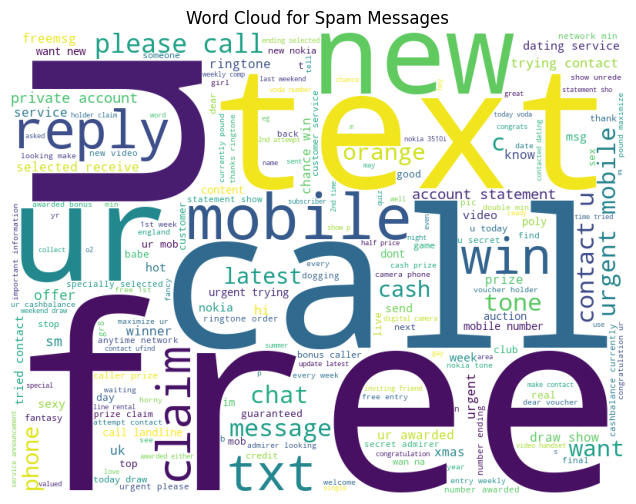

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtering the spam messages
df_spam = df[df['Category'] == 1]

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=600, background_color="white")

# Generate the word cloud
wordcloud.generate(df_spam['lemmatized_text'].to_string())

# Create a figure and display the word cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for Spam Messages")
plt.show()

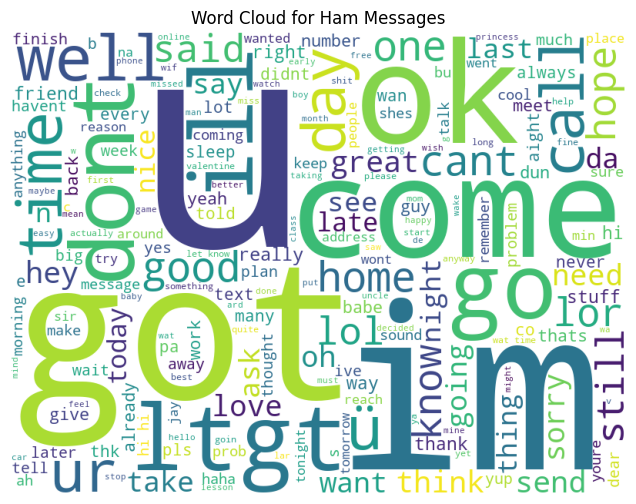

In [30]:
# Filtering the ham messages
df_ham = df[df['Category'] == 0]

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=600, background_color="white")

# Generate the word cloud
wordcloud.generate(df_ham['lemmatized_text'].to_string())

# Create a figure and display the word cloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud for Ham Messages")
plt.show()

> **N-grams:**  
> This sptep allow us to create sequences of n words called Bigrams (2 words) and trigrams (3 words). These N-grams can capture word relationships that single words might miss.

> Single Words vs. Sequences: Individual words might not always convey the full meaning on their own. Bigrams (two-word sequences) and trigrams (three-word sequences) can capture the relationships between words, which can be crucial for tasks like:
> * Sentiment Analysis: "not good" vs. "very good" expresses a clear difference in sentiment.
> * Topic Modeling: Identifying bigrams like "machine learning" or trigrams like "natural language processing" can help identify topics within text data.
> * Machine Translation: Capturing word order and phrasal meaning is essential for accurate translation.

In [31]:
# N-grams (bigrams and trigrams)
from nltk.util import ngrams

def extract_ngrams(tokens, n):
    return list(ngrams(tokens, n))

df['bigrams'] = df['lemmatized'].apply(lambda x: extract_ngrams(x, 2))
df['trigrams'] = df['lemmatized'].apply(lambda x: extract_ngrams(x, 3))

df.head()

,Category,Message,length,words,tokens_nltk,words_nltk,lemmatized,lemmatized_text,bigrams,trigrams
3951,0,I got to video tape pple type in message lor U...,146,34,"[got, video, tape, pple, type, message, lor, u...",27,"[got, video, tape, pple, type, message, lor, u...",got video tape pple type message lor u free wa...,"[(got, video), (video, tape), (tape, pple), (p...","[(got, video, tape), (video, tape, pple), (tap..."
4138,0,Just got to ltgt,17,4,"[got, ltgt]",2,"[got, ltgt]",got ltgt,"[(got, ltgt)]",[]
4710,0,Haha awesome I might need to take you up on th...,70,15,"[haha, awesome, might, need, take, doin, tonight]",7,"[haha, awesome, might, need, take, doin, tonight]",haha awesome might need take doin tonight,"[(haha, awesome), (awesome, might), (might, ne...","[(haha, awesome, might), (awesome, might, need..."
749,0,Is there a reason weve not spoken this year An...,99,21,"[reason, weve, spoken, year, anyways, great, w...",9,"[reason, weve, spoken, year, anyways, great, w...",reason weve spoken year anyways great week bes...,"[(reason, weve), (weve, spoken), (spoken, year...","[(reason, weve, spoken), (weve, spoken, year),..."
3687,0,I get out of class in bsn in like ltgt minut...,75,16,"[get, class, bsn, like, ltgt, minutes, know, a...",8,"[get, class, bsn, like, ltgt, minute, know, ad...",get class bsn like ltgt minute know advising,"[(get, class), (class, bsn), (bsn, like), (lik...","[(get, class, bsn), (class, bsn, like), (bsn, ..."


> Now we need to convert our text message into a numerical representation suitable for machine learning algorithms, an we have to options:
> * TF-IDF: If you want to emphasize the importance of words that are frequent within a document but rare across the corpus (potentially good indicators of spam), TF-IDF might be a better choice.
> * BoW: If a simple word count representation is sufficient for your task, BoW might be a more efficient option.

To potentially improve the accuracy of our spam/ham classification model, we can now incorporate TF-IDF **(Term Frequency-Inverse Document Frequency)**. This technique assigns weights to words based on their frequency within a document and rarity across the entire corpus, potentially highlighting terms that are more indicative of spam text message.

In [32]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit the vectorizer
vectorizer.fit(df['lemmatized_text'])

# Transform the text to a TF-IDF vector
X_tfidf = vectorizer.transform(df['lemmatized_text'])

> **Convert bigrams/trigrams** lists into numerical representations:  

> Use `CountVectorizer` to create a sparse matrix where each row is a message and columns represent unique bigrams/trigrams with their counts.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

def custom_preprocessor(text):
    # Customize preprocessing for lists (e.g., join with a special character)
    return ' '.join(['_'.join(bigram) for bigram in text])


vectorizer_bigrams = CountVectorizer(preprocessor=custom_preprocessor)
vectorizer_bigrams.fit_transform(df['bigrams'])
X_bigrams = vectorizer_bigrams.transform(df['bigrams'])


vectorizer_trigrams = CountVectorizer(preprocessor=custom_preprocessor)
vectorizer_trigrams.fit_transform(df['trigrams'])
X_trigrams = vectorizer_trigrams.transform(df['trigrams'])

> Concatenate these features into a single DataFrame or NumPy array for training your mode

#### 4. Modeling

##### Splitting the data

> Now I will split the data into features/target variable and training and test sets. To do so, we will apply feature `hashing` to bigrams/trigrams for a fixed-size vector representation.

In [34]:
from scipy.sparse import hstack

# Combine the sparse matrices
X_combined = hstack((X_tfidf, X_bigrams, X_trigrams))

y = df['Category']

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


#### **Random forest**

I will start by using `GridSearchCV` to tune a random forest model using parameter as follows:

 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

For this case I will set `refit` to `'f1'` given that:

In this case:

 - Accuracy might be high if the model mostly predicts non-churn (majority class), even if it misses many actual churners (minority class).
 - Precision is valuable to ensure customers flagged as likely to churn actually do churn, minimizing unnecessary interventions.
 - Recall is crucial to identify as many churners as possible, even if it means some false positives (non-churners predicted as churn).
 - F1-score provides a balance between precision and recall, giving a more holistic view of churn prediction performance.

In [36]:
# 1. Instantiate the random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             'class_weight': ['balanced_subsample', 'balanced'],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [37]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 2min 17s
Wall time: 5min 46s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced_subsample', 'balanced'],
                         'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [38]:
# Examine best score
rf_cv.best_score_

0.8740458015267176

> Examine the best combination of hyperparameters.

In [39]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'class_weight': 'balanced',
 'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [41]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'accuracy': [accuracy],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          },
                         )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [42]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,accuracy,precision,recall,F1
0,RF cv,0.896553,0.919452,0.874046,0.896026


#### **XGBoost**

As in Desicion Treen I will be using `GridSearchCV` to tune a random forest model using parameter as follows:

 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

For this case I will also set `refit` to `'f1'` because of the resons I mentioned before.

In [43]:
# 1. Instantiate the XGBoost classifier
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=10)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300],
             'scale_pos_weight': [5, 10],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [44]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 32min 15s
Wall time: 6min 38s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300],
                         'scale_pos_weight': [5, 10]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [45]:
# Examine best score
xgb_cv.best_score_

0.9923664122137404

In [46]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300,
 'scale_pos_weight': 10}

In [47]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,accuracy,precision,recall,F1
0,RF cv,0.896553,0.919452,0.874046,0.896026
0,XGB cv,0.576616,0.547695,0.992366,0.705722


#### 5. Model Selection

Now, I will use the best random forest model and the best XGBoost model to predict on the test data. Whichever performs better will be selected as the champion model.

##### Random Forest

In [48]:
# Use random forest model to predict on test data


rf_test_preds = rf_cv.best_estimator_.predict(X_test)

> The next function will help to generate a table with the scores from the predictions made

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [51]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF Test', rf_test_preds, y_test)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,accuracy,precision,recall,F1
0,RF cv,0.896553,0.919452,0.874046,0.896026
0,XGB cv,0.576616,0.547695,0.992366,0.705722
0,RF Test,0.894942,0.909091,0.854701,0.881057


##### XGBoost Classifier

In [52]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,accuracy,precision,recall,F1
0,RF cv,0.896553,0.919452,0.874046,0.896026
0,XGB cv,0.576616,0.547695,0.992366,0.705722
0,RF Test,0.894942,0.909091,0.854701,0.881057
0,XGB test,0.583658,0.522523,0.991453,0.684366


> Noticed that the Champion Model here is the `Random Forest Classifier` given that the final scores indicate that performed better

> **Random Forest Model Performance:**

> * Accuracy (0.894942): This is a high overall accuracy, exceeding 89%, indicating the model effectively classified most emails in the test set.
> * Precision (0.909091): The precision suggests that out of every 10 emails classified as spam, around 9.0 were actual spam, while the remaining 1.0 were ham emails mistakenly classified as spam (False Positives).
> * Recall (0.854701): This value is slightly lower than the XGBoost model's recall, indicating the XGBoost model captured a larger proportion (nearly 100%) of the actual spam emails in the test set. This means it missed a smaller percentage of spam emails compared to the Random Forest model.
> * F1-Score (0.8690.881057): The F1-score suggests a good balance between precision and recall.

#### 6. Use champion model to predict on test data

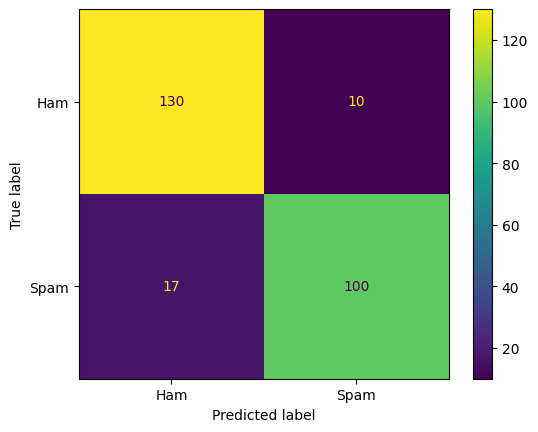

In [54]:
# Use Random Forest model to predict on test data
champion_preds= rf_cv.best_estimator_.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, champion_preds, labels=rf_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Ham', 'Spam'])
disp.plot();

# Save the model to disk
filename = 'rf_model.pkl'
pickle.dump(rf_cv.best_estimator_, open(filename, 'wb'))

**Values in the Matrix:**

Cell (0, 0): True Positive (TP) - Number of correctly classified spam text message.  
Cell (0, 1): False Negative (FN) - Number of spam text message incorrectly classified as ham.  
Cell (1, 0): False Positive (FP) - Number of ham text message incorrectly classified as spam.  
Cell (1, 1): True Negative (TN) - Number of correctly classified ham text message.  

**Conclusion:**

* High TP and Low FP: The model effectively identifies **130** Ham text message with minimal **17** false positives (correctly classifying most actual Ham).
* High TN and Low FN: The model accurately classifies **100** Spam text message, avoiding **10** false negatives (missing very little actual spam).

> I will save it the model using `Pickle` library.

In [56]:
# Save the model to disk

filename = 'rf_model.pkl'
pickle.dump(rf_cv.best_estimator_, open(filename, 'wb'))


In [55]:
# save predicted values to a csv file
df_test = pd.DataFrame({'Message': df.loc[y_test.index, 'Message'],
                        'actual': y_test,
                        'predicted': rf_test_preds})

df_test.to_csv('test_predictions.csv', index=False)

# save the results to a csv file
results.to_csv('results.csv', index=False)
